In [1]:
import csv
import datetime
import math
import matplotlib.pyplot as plt

from collections import defaultdict

KEY_COUNTRY = 1
KEY_DATES_START = 4

# Returns a proper `datetime` from `date_str` in a format like
# '1/22/20', which represents January 22nd, 2020.
def make_date(date_str):
    parts = date_str.split('/')
    assert(len(parts) == 3)
    return datetime.date(2000 + int(parts[2]), int(parts[0]), int(parts[1]))

class DayData(object):
    def __init__(self, confirmed, dead):
        self.confirmed = confirmed
        self.dead = dead

    def __repr__(self):
        return 'c: {}, d: {}'.format(self.confirmed, self.dead)

class Country(object):
    def __init__(self, name, population, kind_data):
        self.name = name
        self.population = population
        self.timeseries = [DayData(confirmed, dead)
            for confirmed, dead in
                zip(kind_data['confirmed'], kind_data['dead'])]

    def __repr__(self):
        return '{}: [{}]'.format(self.name, ', '.join(str(dd) for dd in self.timeseries))

    def _project(self, perm, dayfn):
        factor = 1000.0/self.population if perm else 1.0
        return [dayfn(day) * factor for day in self.timeseries]

    def confirmed(self, perm=False):
        return self._project(perm, lambda day: day.confirmed)

    def dead(self, perm=False):
        return self._project(perm, lambda day: day.dead)

    def dispatch(self, series, perm=False):
        if series == 'confirmed':
            return self.confirmed(perm)
        elif series == 'dead':
            return self.dead(perm)
        else:
            raise Exception('unknown series in dispatch: ' + series)

def read_one_data_series(series):
    country_data = dict()
    with open('data/{}.csv'.format(series)) as fin:
        reader = csv.reader(fin, delimiter=',', quotechar='"')
        header = next(reader)
        dates = [make_date(date_str) for date_str in header[KEY_DATES_START:]]
        for line in reader:
            name = line[KEY_COUNTRY]
            vals = [int(v) for v in line[KEY_DATES_START:]]
            assert(len(vals) == len(dates))
            if name not in country_data:
                country_data[name] = vals
            else:
                # Another province/state for the same country.
                # We just sum this up.
                cur = country_data[name]
                assert(len(cur) == len(vals))
                for i in range(len(cur)):
                    cur[i] += vals[i]
    return dates, country_data

class DB(object):
    def __init__(self):
        self.dates = None
        # {country -> kind -> numbers}
        per_country = defaultdict(dict)
        for series in ['confirmed', 'dead']:
            dates, country_data = read_one_data_series(series)
            if self.dates is None:
                self.dates = dates
            else:
                # We're assuming all the dates are present in all the datasets.
                assert(self.dates == dates)
            if len(per_country) > 0:
                assert(set(per_country.keys()) == set(country_data.keys()))
            for country, vals in country_data.items():
                per_country[country][series] = vals

        # {country name -> population}
        populations = dict()
        with open('data/country_population.txt') as fin:
            for line in fin:
                parts = line.split(' ')
                populations[' '.join(parts[:-1])] = int(parts[-1])
        self.countries = dict()
        for name, kind_data in per_country.items():
            try:
                pop = populations[name]
            except:
                pop = 0
            self.countries[name] = Country(name, pop, kind_data)

    def country(self, country_name):
        return self.countries[country_name]

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

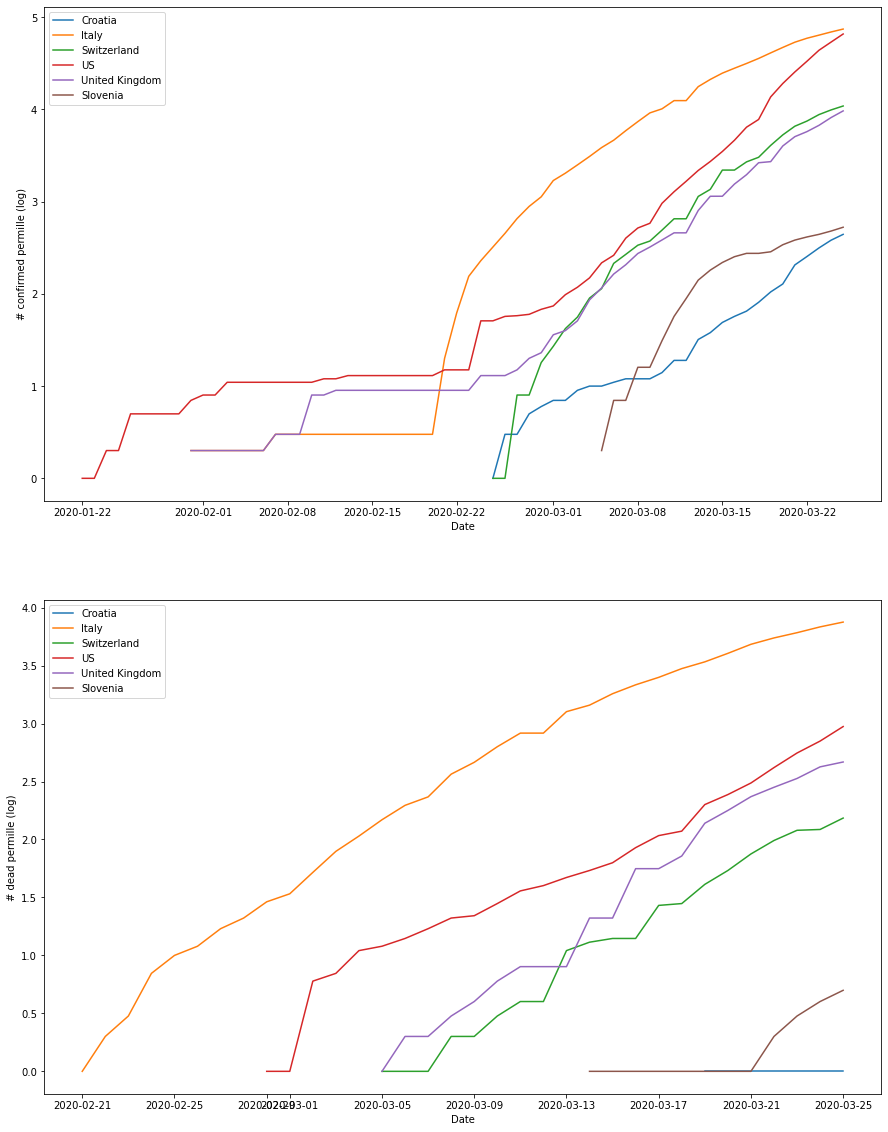

In [3]:
def log(lst):
    return [None if x == 0 else math.log10(x) for x in lst]

db = DB()

countries_to_plot = ['Croatia', 'Italy', 'Switzerland', 'US', 'United Kingdom', 'Slovenia']
fig, axes = plt.subplots(2, 1, figsize=(15, 20))

for i, series in enumerate(['confirmed', 'dead']):
    ax = axes[i];
    for cname in countries_to_plot:
        ax.plot(db.dates, log(db.country(cname).dispatch(series)), label=cname)
    ax.set_ylabel('# {} permille (log)'.format(series))
    ax.set_xlabel('Date')
    ax.legend()

plt.show()

Croatia start date 2020-02-29
Best fit exponential: 1.2867180191604222 * exp10(0.09837176825192541 * t)
Best fit sigmoid: 1142.2853518681397 / (1.0 + exp10(-0.12531955013192828 * (t - 27.478892643650177)))


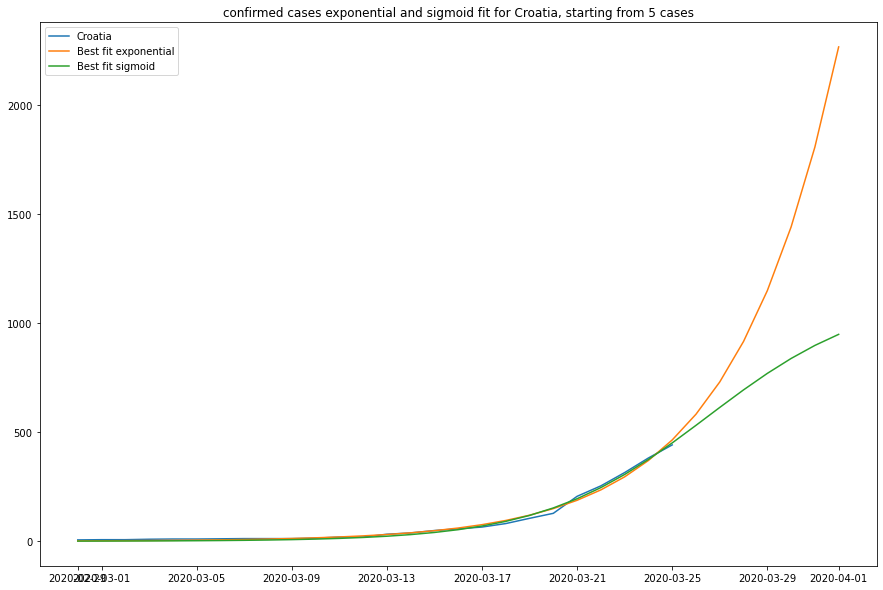

Italy start date 2020-02-21
Best fit exponential: 1098.298266321936 * exp10(0.0549748142117084 * t)
Best fit sigmoid: 112297.19961433893 / (1.0 + exp10(-0.08672339014344319 * (t - 30.598500222187955)))


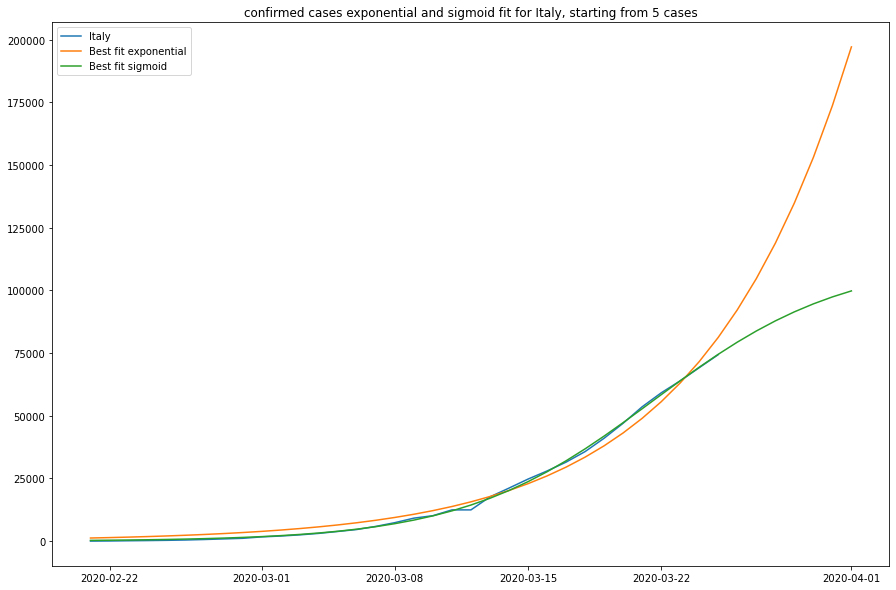

Switzerland start date 2020-02-27
Best fit exponential: 79.64317074228934 * exp10(0.07754256623868871 * t)
Best fit sigmoid: 17512.556477911905 / (1.0 + exp10(-0.11926185709575192 * (t - 26.078490551329608)))


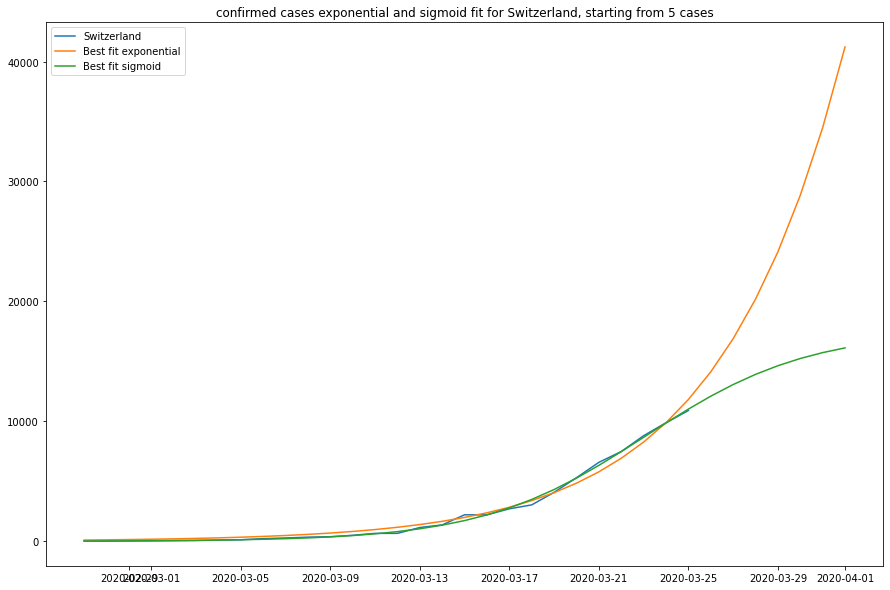

US start date 2020-01-31
Best fit exponential: 0.03540399050635623 * exp10(0.11433284914492961 * t)
Best fit sigmoid: 121934.91654667062 / (1.0 + exp10(-0.16250490308561913 * (t - 54.59049142321563)))


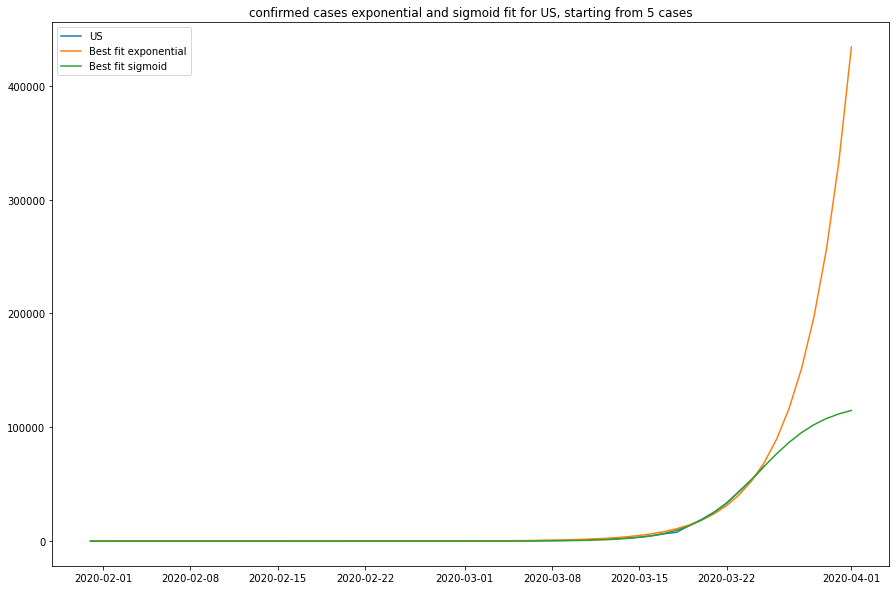

United Kingdom start date 2020-02-10
Best fit exponential: 1.3740231657488562 * exp10(0.08577335944193114 * t)
Best fit sigmoid: 23274.080315882726 / (1.0 + exp10(-0.10914490562873758 * (t - 46.423753685689334)))


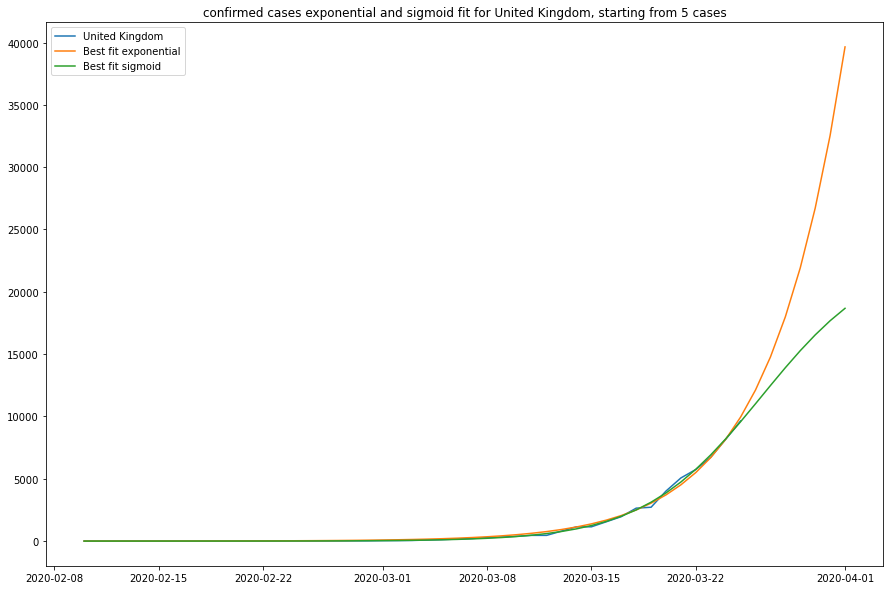

Slovenia start date 2020-03-06
Best fit exponential: 51.358715055457864 * exp10(0.05231690552536761 * t)
Best fit sigmoid: 565.0940932542769 / (1.0 + exp10(-0.11657171624393244 * (t - 12.8262488908405)))


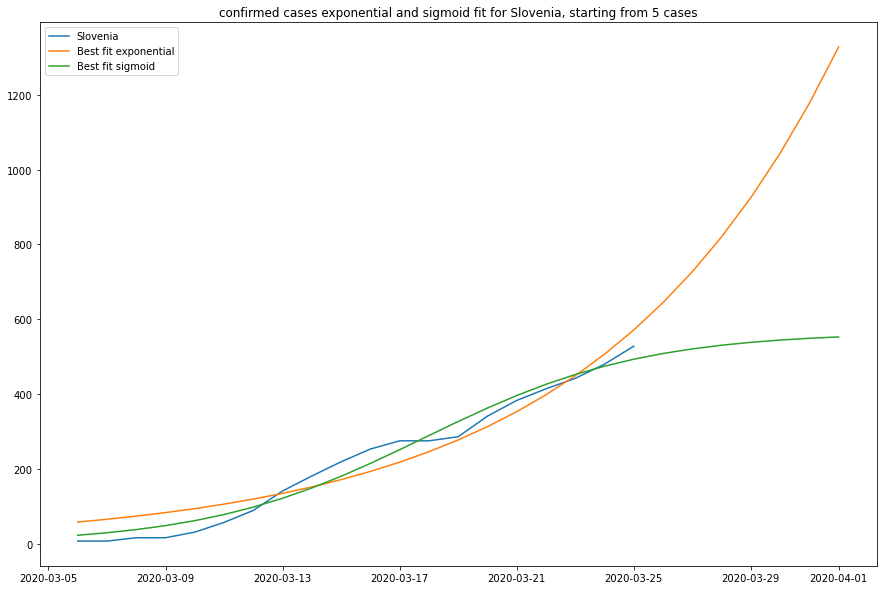

In [4]:
import numpy as np

from scipy.optimize import curve_fit
from scipy.special import exp10

def get_start_and_align(country_name, series, start_val, perm):
    data = db.country(country_name).dispatch(series, perm=perm)
    for i, (t, val) in enumerate(zip(db.dates, data)):
        if val > start_val:
            return db.dates[i:], data[i:]

def exponential(t, a, b):
    return a * exp10(b * t)

def sigmoid(t, a, b, c):
    return a / (1.0 + exp10(-b * (t - c)))

DAYS_EXTEND = 7

def country_exp_vs_sigmoid(country, series):
    dates, data = get_start_and_align(country, series, 5, perm=False)
    print('{} start date {}'.format(country, dates[0]))
    (aexp, bexp), _ = curve_fit(exponential, np.arange(1, len(data) + 1), data, p0=(1, 0.3))
    print('Best fit exponential: {} * exp10({} * t)'.format(aexp, bexp))
    (asig, bsig, csig), _ = curve_fit(sigmoid, np.arange(1, len(data) + 1), data, p0=(data[-1], 0.2, 21))
    print('Best fit sigmoid: {} / (1.0 + exp10(-{} * (t - {})))'.format(asig, bsig, csig))

    ts_extended = np.arange(1, len(data) + 1 + DAYS_EXTEND)
    dates_extended = dates[::] + [dates[-1] + datetime.timedelta(days=d) for d in range(1, DAYS_EXTEND + 1)]
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(dates, data, label=country)
    ax.plot(dates_extended, exponential(ts_extended, aexp, bexp), label='Best fit exponential')
    ax.plot(dates_extended, sigmoid(ts_extended, asig, bsig, csig), label='Best fit sigmoid')
    ax.set_title('{} cases exponential and sigmoid fit for {}, starting from 5 cases'.format(series, country))
    ax.legend()
    plt.show()

for country in countries_to_plot:
    country_exp_vs_sigmoid(country, 'confirmed')

Korea, South start date 2020-01-31
Best fit exponential: 640.3977808158553 * exp10(0.022954941175664562 * t)
Best fit sigmoid: 8603.67442879498 / (1.0 + exp10(-0.13095340468917332 * (t - 32.134854604378255)))


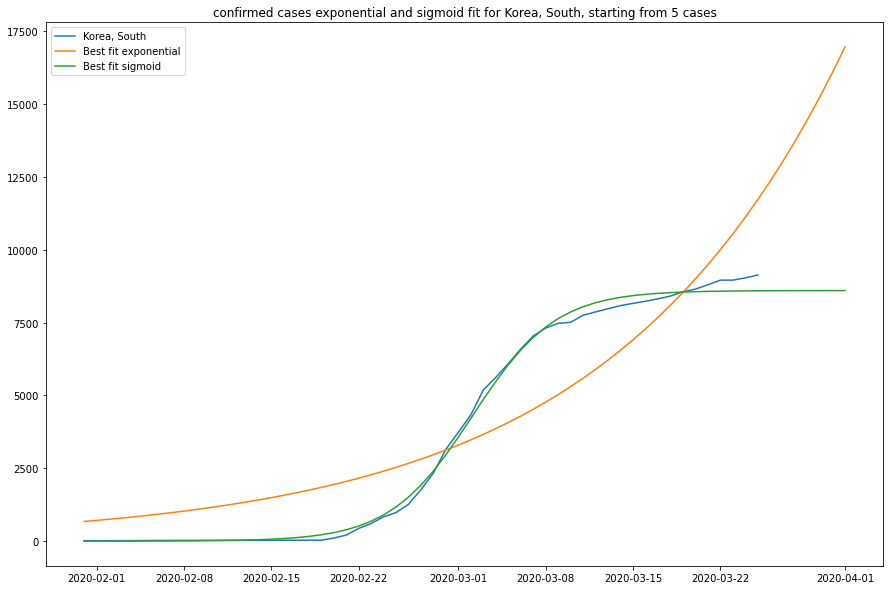

Japan start date 2020-01-28
Best fit exponential: 29.899503512909973 * exp10(0.02863594715335635 * t)
Best fit sigmoid: 1705.3236819340482 / (1.0 + exp10(-0.04753804935204959 * (t - 49.471741571932)))


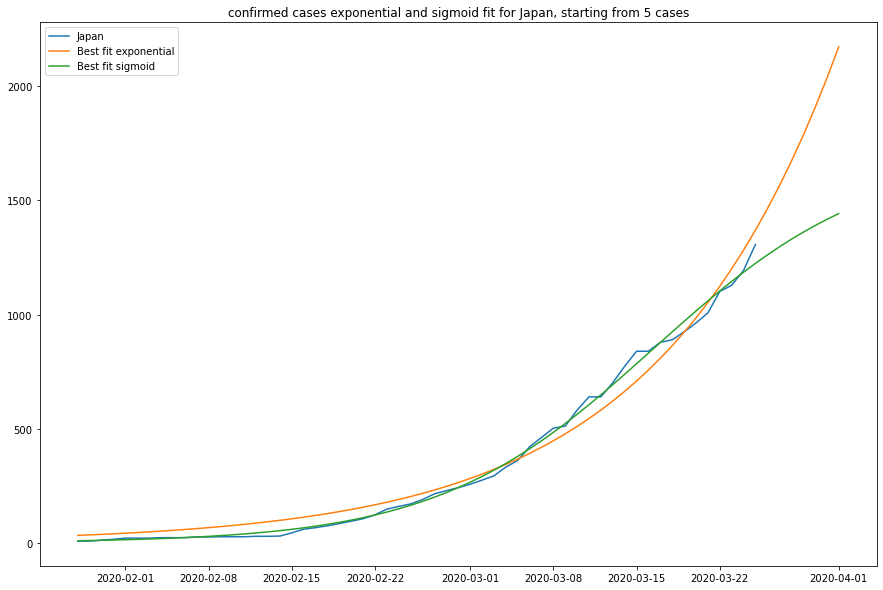

China start date 2020-01-22
Best fit exponential: 28444.67199710826 * exp10(0.00876869819835504 * t)
Best fit sigmoid: 81043.19502330942 / (1.0 + exp10(-0.09615019822767365 * (t - 18.77653595034828)))


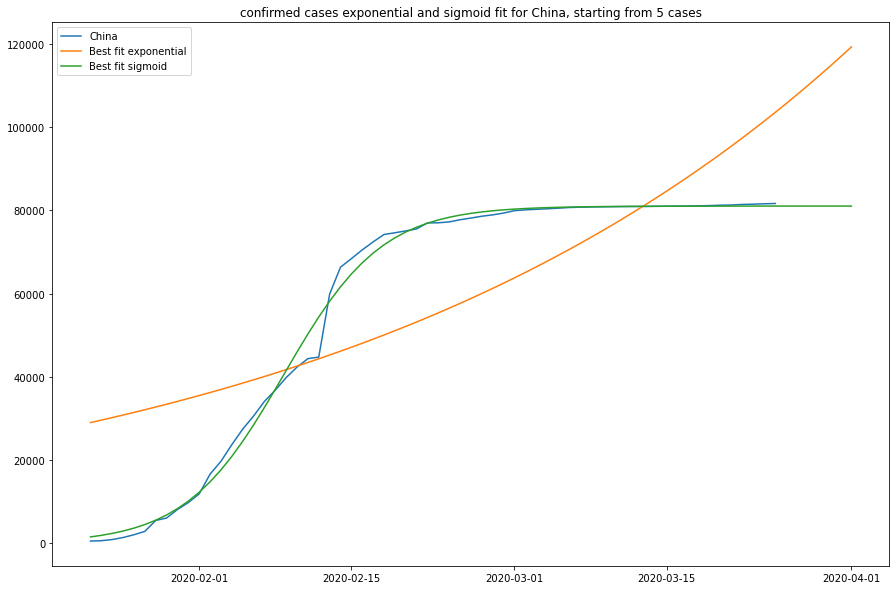

In [5]:
recovering_countries = ['Korea, South', 'Japan', 'China']
for country in recovering_countries:
    country_exp_vs_sigmoid(country, 'confirmed')

Best fit exponential Croatia: 0.00012693461343466552 * exp10(0.09833925333543042 * t)
Best fit exponential Italy: 0.01816511907002976 * exp10(0.05497484007878421 * t)
Best fit exponential Switzerland: 0.006426692776559872 * exp10(0.07757212176002606 * t)
Best fit exponential US: 5.9320630185767307e-05 * exp10(0.11433296276358473 * t)
Best fit exponential United Kingdom: 2.024020739652109e-05 * exp10(0.0857733316278644 * t)
Best fit exponential Slovenia: 0.021254652356629777 * exp10(0.0530194030751132 * t)


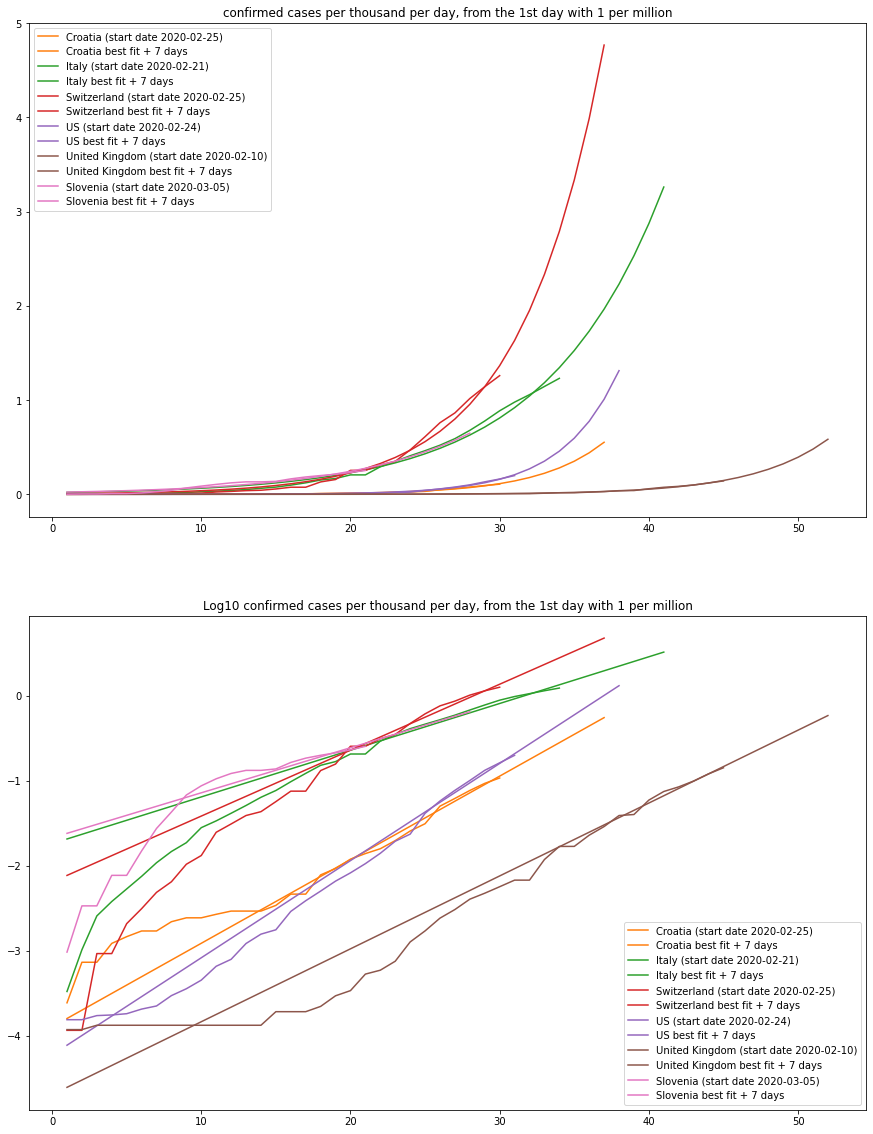

In [6]:
def identity(lst):
    return lst

def compare_countries(series, countries, start_value=(0.0001, '1 per million')):
    fig, axes = plt.subplots(2, 1, figsize=(15, 20))

    for cidx, country in enumerate(countries):
        # Start each country when they had 1 case per million.
        dates, data = get_start_and_align(country, series, start_value[0], perm=True)
        data_label = '{} (start date {})'.format(country, dates[0])
        fit_label = '{} best fit + {} days'.format(country, DAYS_EXTEND)
        xs = np.arange(1, len(data) + 1)
        (aexp, bexp), _ = curve_fit(exponential, xs, data, p0=(1, 0.3))
        print('Best fit exponential {}: {} * exp10({} * t)'.format(country, aexp, bexp))
    
        xs_extended = np.arange(1, len(xs) + 1 + DAYS_EXTEND)
        color = 'C{}'.format(cidx + 1)
    
        for fnidx, fn in enumerate([identity, log]):
            ax = axes[fnidx]
            ax.plot(xs, fn(data), color, label=data_label)
            ax.plot(xs_extended, fn(exponential(xs_extended, aexp, bexp)), color, label=fit_label)

    axes[0].legend()
    axes[0].set_title('{} cases per thousand per day, from the 1st day with {}'.format(series, start_value[1]))
    axes[1].legend()
    axes[1].set_title('Log10 {} cases per thousand per day, from the 1st day with {}'.format(series, start_value[1]))
    plt.show()
    
compare_countries('confirmed', countries_to_plot)

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Best fit exponential Croatia: 0.00024358951536011293 * exp10(1.1358268458954037e-10 * t)
Best fit exponential Italy: 0.0007653303030811251 * exp10(0.06591666430943638 * t)
Best fit exponential Switzerland: 0.00019166139828246244 * exp10(0.0947024169641196 * t)
Best fit exponential US: 2.6340374554929623e-06 * exp10(0.11656896682161516 * t)
Best fit exponential United Kingdom: 5.840670672994278e-05 * exp10(0.10037371829549206 * t)
Best fit exponential Slovenia: 0.00011574690615443573 * exp10(0.10879090538652177 * t)


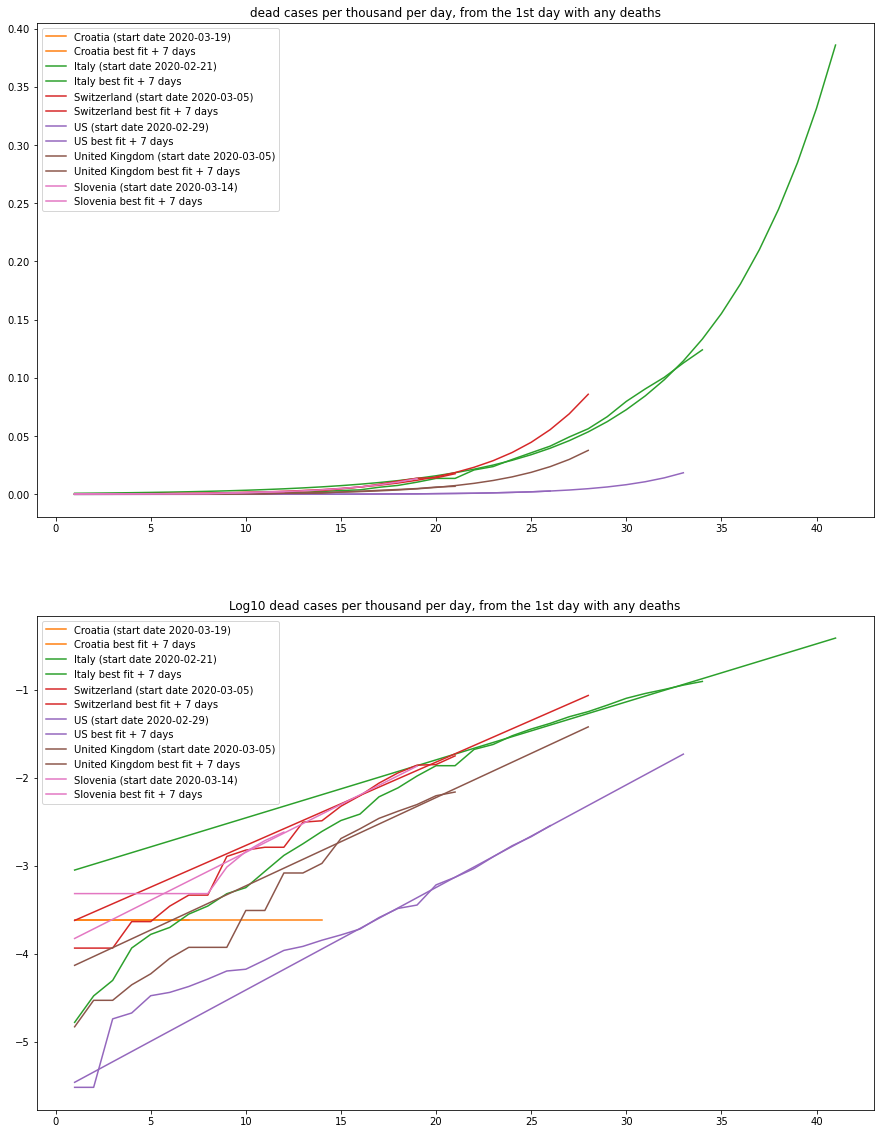

In [7]:
# Not reliable for many of these countries as they are still in early stages!
compare_countries('dead', countries_to_plot, start_value=(0, 'any deaths'))